<a href="https://www.kaggle.com/code/kriggs/bellabeat-case-study-2-3-feature-selection?scriptVersionId=142870750" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# BellaBeat Case Study 2/3 - Feature Selection

In this notebook I'll be selecting explanatory features from the Bellabeat Dataset for the modelling of a ML algorith to detect abnormal heart rate conditions.

The inspiration for this modelling is explained in the 3rd notebook.

This Study is split into 3 parts:
- Part 1 - Data exploration and inspiration to the question  
    https://www.kaggle.com/code/kriggs/bellabeat-case-study-1-3-data-exploration

- Part 2 - Feature selection  
    This notebook

- Part 3 - ML Modelling  
    https://www.kaggle.com/kriggs/bellabeat-case-study-3-3-ml-modelling

In [1]:
# Imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image

no_top_left_bar = {"axes.spines.right": False, "axes.spines.top": False}
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading datasets

data_dir = '../datasets/'

relevant_minutes_datasets = [
    data_dir + 'minuteMETsNarrow_merged.csv',
    data_dir + 'minuteStepsNarrow_merged.csv',
    data_dir + 'minuteIntensitiesNarrow_merged.csv',
    data_dir + 'minuteCaloriesNarrow_merged.csv',
    data_dir + 'heartrate_seconds_merged.csv'
]

dfs_minutes = []

dict_rename_date_cols = {
    'Date': 'Time',
    'ActivityMinute':'Time',
    'date': 'Time',
    'Value':'heart_rate'
}

for ds in relevant_minutes_datasets:
    dfs_minutes.append(pd.read_csv(ds).rename(columns=dict_rename_date_cols))

for i_df in range(len(dfs_minutes)):
    dfs_minutes[i_df]['Time'] = pd.to_datetime(dfs_minutes[i_df]['Time'], format=r'%m/%d/%Y %I:%M:%S %p')

In [3]:
# Time bining in 1min frequency

freq = '1 min'
df_concat = pd.concat(dfs_minutes, ignore_index=True)
five_min_cut = pd.date_range(start=df_concat['Time'].min(), freq=freq, end=(df_concat['Time'].max() + pd.Timedelta(freq)))
df_concat.loc[:, 'time_range'] = pd.cut(df_concat['Time'], five_min_cut, include_lowest=True)
df_concat.head()

Id                Time  METs  Steps  Intensity  Calories  heart_rate                                         time_range
0  1503960366 2016-04-12 00:00:00  10.0    NaN        NaN       NaN         NaN  (2016-04-11 23:59:59.999999999, 2016-04-12 00:...
1  1503960366 2016-04-12 00:01:00  10.0    NaN        NaN       NaN         NaN  (2016-04-11 23:59:59.999999999, 2016-04-12 00:...
2  1503960366 2016-04-12 00:02:00  10.0    NaN        NaN       NaN         NaN         (2016-04-12 00:01:00, 2016-04-12 00:02:00]
3  1503960366 2016-04-12 00:03:00  10.0    NaN        NaN       NaN         NaN         (2016-04-12 00:02:00, 2016-04-12 00:03:00]
4  1503960366 2016-04-12 00:04:00  10.0    NaN        NaN       NaN         NaN         (2016-04-12 00:03:00, 2016-04-12 00:04:00]

In [4]:
# Aggregating the bins with the min, max and mean values

df_grouped = df_concat.groupby(['Id', 'time_range']).agg(['min', 'max', 'mean'])
df_grouped = (df_grouped.set_axis(df_grouped.columns.map('_'.join), axis=1).
              drop(columns=['Time_max', 'Time_mean']).
              rename(columns={'Time_min':'Time'}))

df_grouped.head()

Time  METs_min  METs_max  METs_mean  Steps_min  Steps_max  Steps_mean  Intensity_min  Intensity_max  Intensity_mean  Calories_min  Calories_max  Calories_mean  heart_rate_min  heart_rate_max  heart_rate_mean
Id         time_range                                                                                                                                                                                                                                                                       
1503960366 (2016-04-11 23:59:59.999999999, 2016-04-12 00:0... 2016-04-12 00:00:00      10.0      10.0       10.0        0.0        0.0         0.0            0.0            0.0             0.0        0.7865        0.7865         0.7865             NaN             NaN              NaN
           (2016-04-12 00:01:00, 2016-04-12 00:02:00]         2016-04-12 00:02:00      10.0      10.0       10.0        0.0        0.0         0.0            0.0            0.0             0.0        0.7865        0.7865         0.7865             NaN             NaN              NaN
           (2016-04-12 00:02:00, 2016-04-12 00:03:00]         2016-04-12 00:03:00      10.0      10.0       10.0        0.0        0.0         0.0            0.0            0.0             0.0        0.7865        0.7865         0.7865             NaN             NaN              NaN
           (2016-04-12 00:03:00, 2016-04-12 00:04:00]         2016-04-12 00:04:00      10.0      10.0       10.0        0.0        0.0         0.0            0.0            0.0             0.0        0.7865        0.7865         0.7865             NaN             NaN              NaN
           (2016-04-12 00:04:00, 2016-04-12 00:05:00]         2016-04-12 00:05:00      12.0      12.0       12.0        0.0        0.0         0.0            0.0            0.0             0.0        0.9438        0.9438         0.9438             NaN             NaN              NaN

Percentage of each column with NaN values

In [5]:
pd.DataFrame(df_grouped.isna().sum() / len(df_grouped)).T.style.format('{:.2%}')

Removing NaN and setting the name column

In [6]:
df_grouped = df_grouped.dropna().reset_index()
df_grouped['Name'] = df_grouped['Id'].replace(pd.read_csv('../output_files/id_to_names.csv').set_index('Unnamed: 0').to_dict()['Names'])
print('Shape: ', df_grouped.shape)
df_grouped.head()

Shape:  (333464, 19)


Id                                  time_range                Time  METs_min  METs_max  METs_mean  Steps_min  Steps_max  Steps_mean  Intensity_min  Intensity_max  Intensity_mean  Calories_min  Calories_max  Calories_mean  heart_rate_min  heart_rate_max  heart_rate_mean   Name
0  2022484408  (2016-04-12 07:20:00, 2016-04-12 07:21:00] 2016-04-12 07:21:00      32.0      32.0       32.0       17.0       17.0        17.0            1.0            1.0             1.0       3.32064       3.32064        3.32064            97.0            97.0        97.000000  James
1  2022484408  (2016-04-12 07:21:00, 2016-04-12 07:22:00] 2016-04-12 07:21:05      38.0      38.0       38.0        9.0        9.0         9.0            1.0            1.0             1.0       3.94326       3.94326        3.94326           101.0           105.0       102.750000  James
2  2022484408  (2016-04-12 07:22:00, 2016-04-12 07:23:00] 2016-04-12 07:22:05      13.0      13.0       13.0        0.0        0.0         0.0            0.0            0.0             0.0       1.34901       1.34901        1.34901            60.0            95.0        85.100000  James
3  2022484408  (2016-04-12 07:23:00, 2016-04-12 07:24:00] 2016-04-12 07:23:10      10.0      10.0       10.0        0.0        0.0         0.0            0.0            0.0             0.0       1.03770       1.03770        1.03770            54.0            61.0        57.666667  James
4  2022484408  (2016-04-12 07:24:00, 2016-04-12 07:25:00] 2016-04-12 07:24:10      10.0      10.0       10.0        0.0        0.0         0.0            0.0            0.0             0.0       1.03770       1.03770        1.03770            56.0            60.0        58.000000  James

# Checking the data correlation

In [7]:
def hightlight_1(val):
    color = 'red' if val == 1 else ''
    return 'color: %s' % color

df_grouped._get_numeric_data().drop(columns=['Id']).corr().style.applymap(lambda x: "background-color: red" if x > 0.95 else "")

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000"><font color='#125899'>

##  Inference Correlation </font>
   
<li> The min/max/mean values are all too correlated to be of any value to be used togheter, only the mean value will be left
<li> Calories and METs have an extremely high correlation, possibility is that these features are calculated of one another
</div>


In [8]:
# Removing all features min/max column

df_grouped = df_grouped.drop(columns=[
	'METs_min', 'METs_max',
	'Steps_min', 'Steps_max',
	'Intensity_min','Intensity_max',
	'Calories_min', 'Calories_max',
	'heart_rate_max', 'heart_rate_min'
]).rename(columns={
	c:c.replace('_mean', '') for c in df_grouped.columns
})

df_grouped.head()

Id                                  time_range                Time  METs  Steps  Intensity  Calories  heart_rate   Name
0  2022484408  (2016-04-12 07:20:00, 2016-04-12 07:21:00] 2016-04-12 07:21:00  32.0   17.0        1.0   3.32064   97.000000  James
1  2022484408  (2016-04-12 07:21:00, 2016-04-12 07:22:00] 2016-04-12 07:21:05  38.0    9.0        1.0   3.94326  102.750000  James
2  2022484408  (2016-04-12 07:22:00, 2016-04-12 07:23:00] 2016-04-12 07:22:05  13.0    0.0        0.0   1.34901   85.100000  James
3  2022484408  (2016-04-12 07:23:00, 2016-04-12 07:24:00] 2016-04-12 07:23:10  10.0    0.0        0.0   1.03770   57.666667  James
4  2022484408  (2016-04-12 07:24:00, 2016-04-12 07:25:00] 2016-04-12 07:24:10  10.0    0.0        0.0   1.03770   58.000000  James

## Plotting the correlations

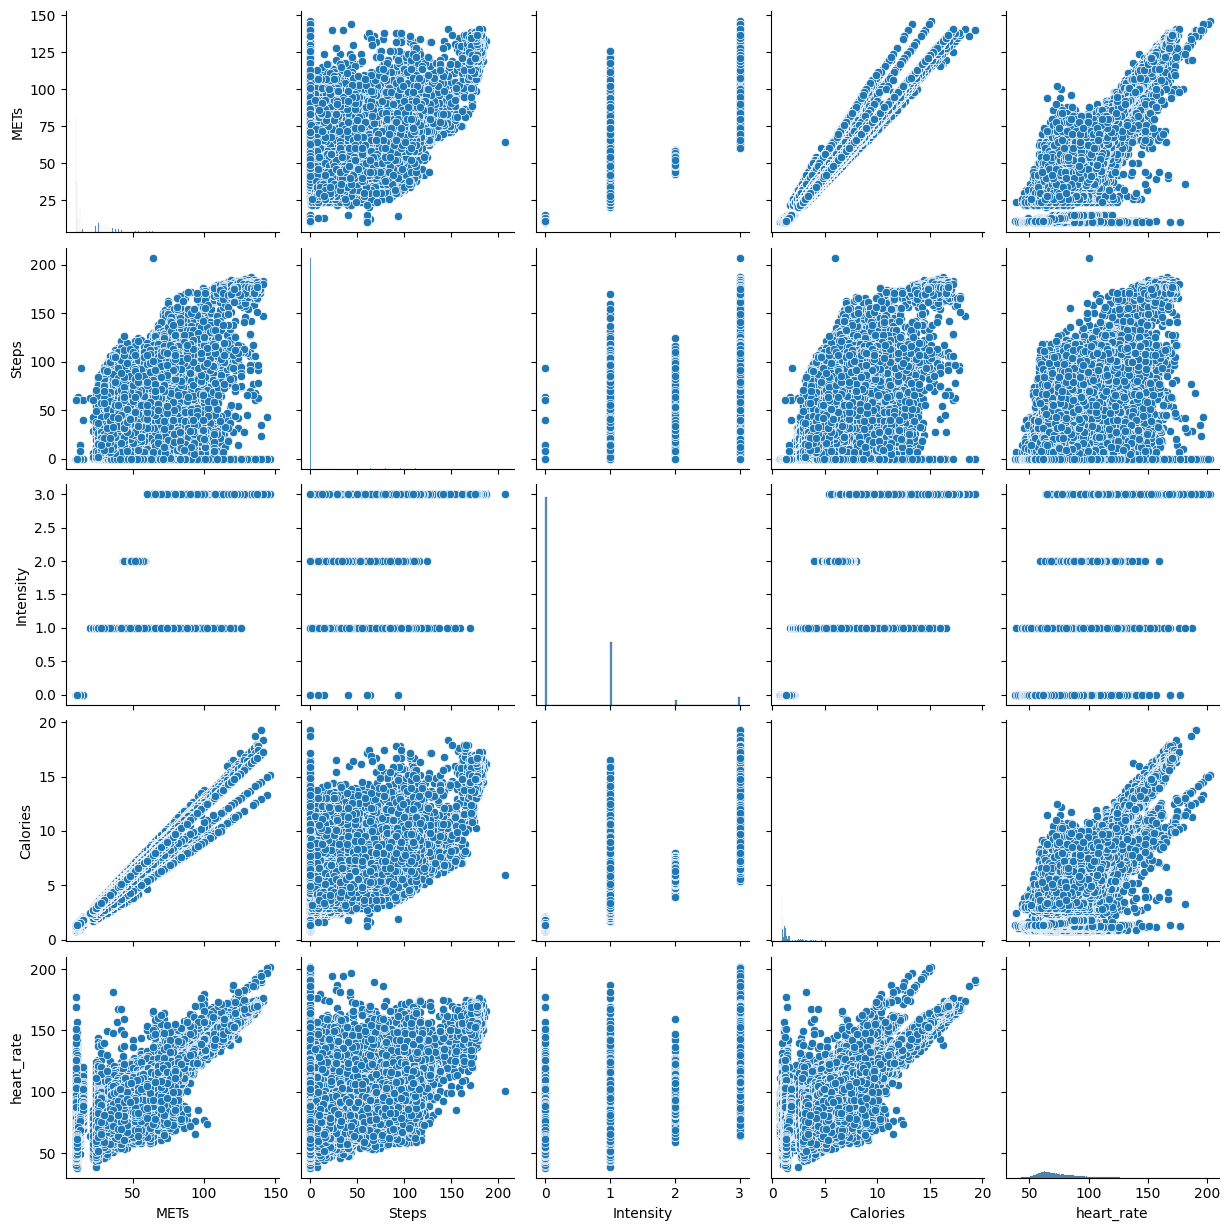

In [9]:
sns.pairplot(data=df_grouped._get_numeric_data().drop(columns=['Id']))

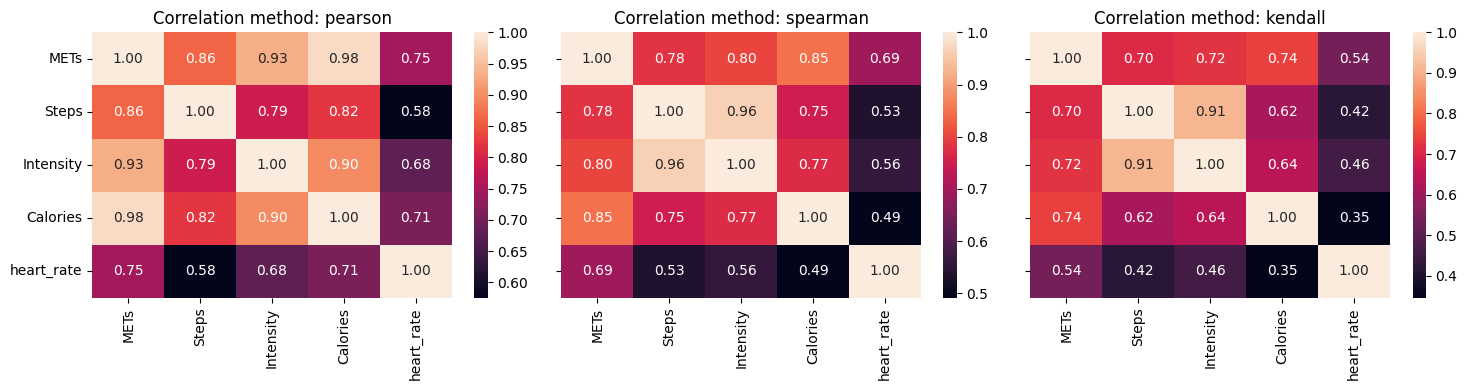

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15,4), sharey=True)
axs = iter(axs.flatten())

for m in ['pearson', 'spearman', 'kendall']:
    ax = next(axs)
    curr_df = df_grouped._get_numeric_data().drop(columns=['Id'])
    
    sns.heatmap(curr_df.corr(method=m), annot=True, ax=ax, fmt=".2f")
    ax.set_title(f'Correlation method: {m}')
    
fig.tight_layout()

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000"><font color='#125899'>

##  Inference Feature Correlation </font>
   
<li> All the explanatory variables (METs, Steps, Intensity, Calorie) are very high correlated (> 0.7)
<li> To continue this study, homewever, we'll include 2 explanatory variables, Steps, which has the least correlation with the other explanatory variables, and METs, which is very highly lineary correlated with Calories and intensity
<li> Since the Spearman's correlation for Steps and Intensity is greater than the Pearson's correlation, the relationship between these two variables are expected to be monotonic but not completely linear

</div>

In [11]:
# Removing unnecessary columns

df_reduced = df_grouped.drop(columns=['Calories', 'Intensity'])
df_reduced.head()

Id                                  time_range                Time  METs  Steps  heart_rate   Name
0  2022484408  (2016-04-12 07:20:00, 2016-04-12 07:21:00] 2016-04-12 07:21:00  32.0   17.0   97.000000  James
1  2022484408  (2016-04-12 07:21:00, 2016-04-12 07:22:00] 2016-04-12 07:21:05  38.0    9.0  102.750000  James
2  2022484408  (2016-04-12 07:22:00, 2016-04-12 07:23:00] 2016-04-12 07:22:05  13.0    0.0   85.100000  James
3  2022484408  (2016-04-12 07:23:00, 2016-04-12 07:24:00] 2016-04-12 07:23:10  10.0    0.0   57.666667  James
4  2022484408  (2016-04-12 07:24:00, 2016-04-12 07:25:00] 2016-04-12 07:24:10  10.0    0.0   58.000000  James

In [12]:
# Check how many values each name has with how many days

df_count_days_names = df_reduced.groupby([df_reduced.Time.dt.strftime('%m-%d'), 'Name'])['Id'].count()

print('Number of days each participant logged for more than 10 hours')
df_count_days_names[(df_count_days_names > 10 * 60)].reset_index().groupby('Name').Name.count().sort_values(ascending=False)

Number of days each participant logged for more than 10 hours


Name
David        31
John         29
Susan        29
Jennifer     28
Michael      28
Linda        27
James        25
Barbara      22
William      20
Robert       17
Richard      16
Patricia      8
Elizabeth     3
Name: Name, dtype: int64

<div style="border-radius:10px; border:#125899 solid; padding: 15px; background-color: #a3bfd9; font-size:100%; text-align:left; color: #000000"><font color='#125899'>

##  Inference Days Logged </font>
   
<li> A better analysis can be conducted on days that had longer tracking, as such, only days that hat more than 10 hours will be used
<li> Furthermore, only participants that had more than 10 days logged for more than 10 hours will be used

</div>

In [13]:
# Creating DF with aforementioned restrictions

df_only_more_10_days = df_reduced.set_index([df_reduced.Time.dt.strftime('%m-%d'), 'Name']).loc[df_count_days_names[(df_count_days_names > 10 * 60)].index]
df_only_more_10_days.index = df_only_more_10_days.index.rename({'Time':'date'})
df_only_more_10_days = df_only_more_10_days.reset_index()
df_only_more_10_days.head()

date     Name          Id                                  time_range                Time  METs  Steps  heart_rate
0  04-12  Barbara  7007744171  (2016-04-12 05:36:00, 2016-04-12 05:37:00] 2016-04-12 05:36:30  10.0    0.0  101.000000
1  04-12  Barbara  7007744171  (2016-04-12 06:03:00, 2016-04-12 06:04:00] 2016-04-12 06:03:05  10.0    0.0   70.000000
2  04-12  Barbara  7007744171  (2016-04-12 06:26:00, 2016-04-12 06:27:00] 2016-04-12 06:26:30  30.0   10.0   97.250000
3  04-12  Barbara  7007744171  (2016-04-12 06:27:00, 2016-04-12 06:28:00] 2016-04-12 06:27:05  36.0   28.0   98.800000
4  04-12  Barbara  7007744171  (2016-04-12 06:28:00, 2016-04-12 06:29:00] 2016-04-12 06:28:05  40.0   45.0  101.888889

# Cases selection

The next part of this study would be to talk to a expert in the field and delimit the days and patients which had a normal heart rate to METs/Steps.

As this is just a study I will be doing the part of data selection as well, in these next few blocks I will be exporting the data for visualization and selecting manually which data I seem to find fit for a regular HR to METs/Steps.

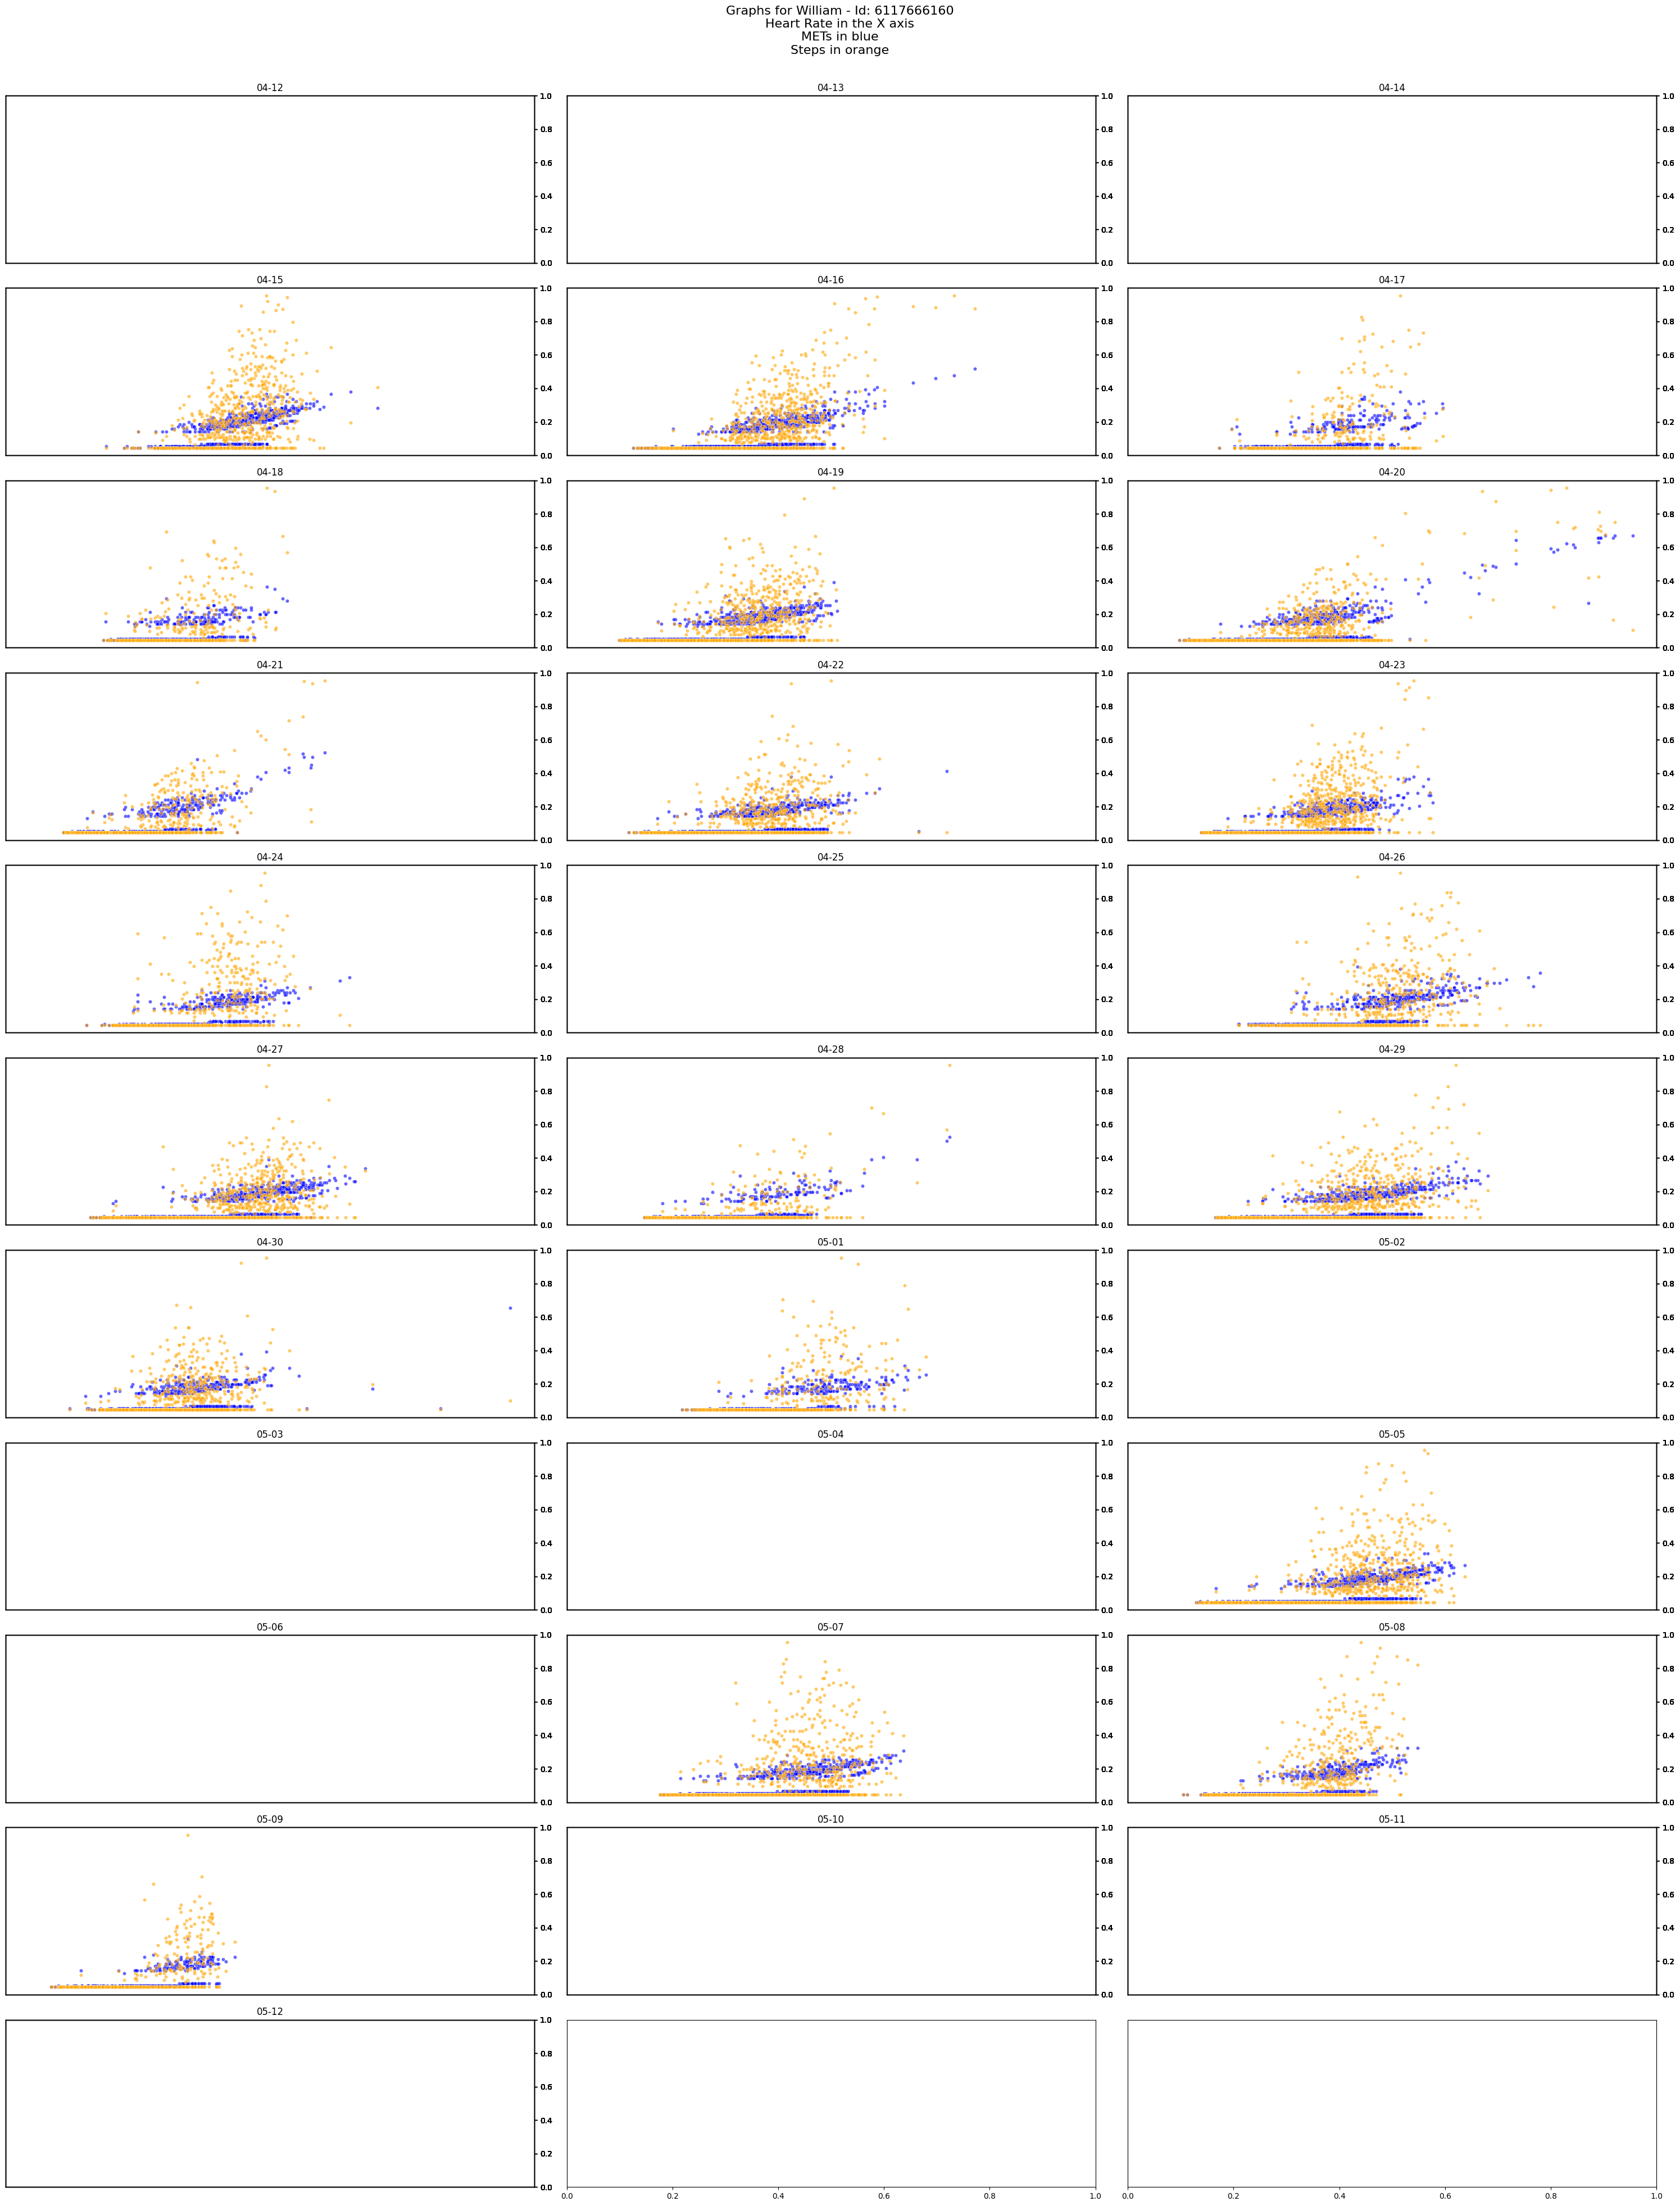

In [14]:
# Saving the graphs in a folder for easier analysis
all_ids = df_only_more_10_days['Id'].unique()
all_days = df_only_more_10_days['date'].unique()

n_cols = 3
fig, axs = plt.subplots(int(np.ceil(len(all_days) / n_cols)), n_cols, figsize=(30,40), sharey=True)
axs = axs.flatten()
twinaxs = []

for id in all_ids:
	df_curr_id = df_only_more_10_days[df_only_more_10_days['Id'] == id]
	for i_day, day in enumerate(all_days[:]):
		curr_ax = axs[i_day]
		df_curr_id_day = df_curr_id[df_curr_id['date'] == day]
		scatter_size = 20
		scatter_alpha = 0.6
		sns.scatterplot(data=df_curr_id_day, x='heart_rate', y='METs', ax=curr_ax, color='blue', alpha=scatter_alpha, s=scatter_size)
		twinaxs.append(sns.scatterplot(data=df_curr_id_day, x='heart_rate', y='Steps', ax=curr_ax.twinx(), color='orange', alpha=scatter_alpha, s=scatter_size))

		curr_ax.set(
			xticks=[],
			xlabel='',
			title=day,
			ylabel='',
			yticks=[]
		)

		twinaxs[-1].set(
			ylabel='',
			yticks=[]
		)
		
	fig.suptitle(f'Graphs for {df_curr_id.Name.iloc[0]} - Id: {id}\n'+
					'Heart Rate in the X axis\n'+
					'METs in blue\n'+
					'Steps in orange', fontsize=16)
	
	fig.tight_layout()
	fig.subplots_adjust(top=0.94)
	plt.savefig('Graphs_heart_rate_METs_Steps/' + df_curr_id.Name.iloc[0])
	
	if id != all_ids[-1]:
		for ax1, ax2 in zip(axs, twinaxs):
			ax1.cla()
			ax2.cla()
			twinaxs = []

## Example of selected graphs for training the model

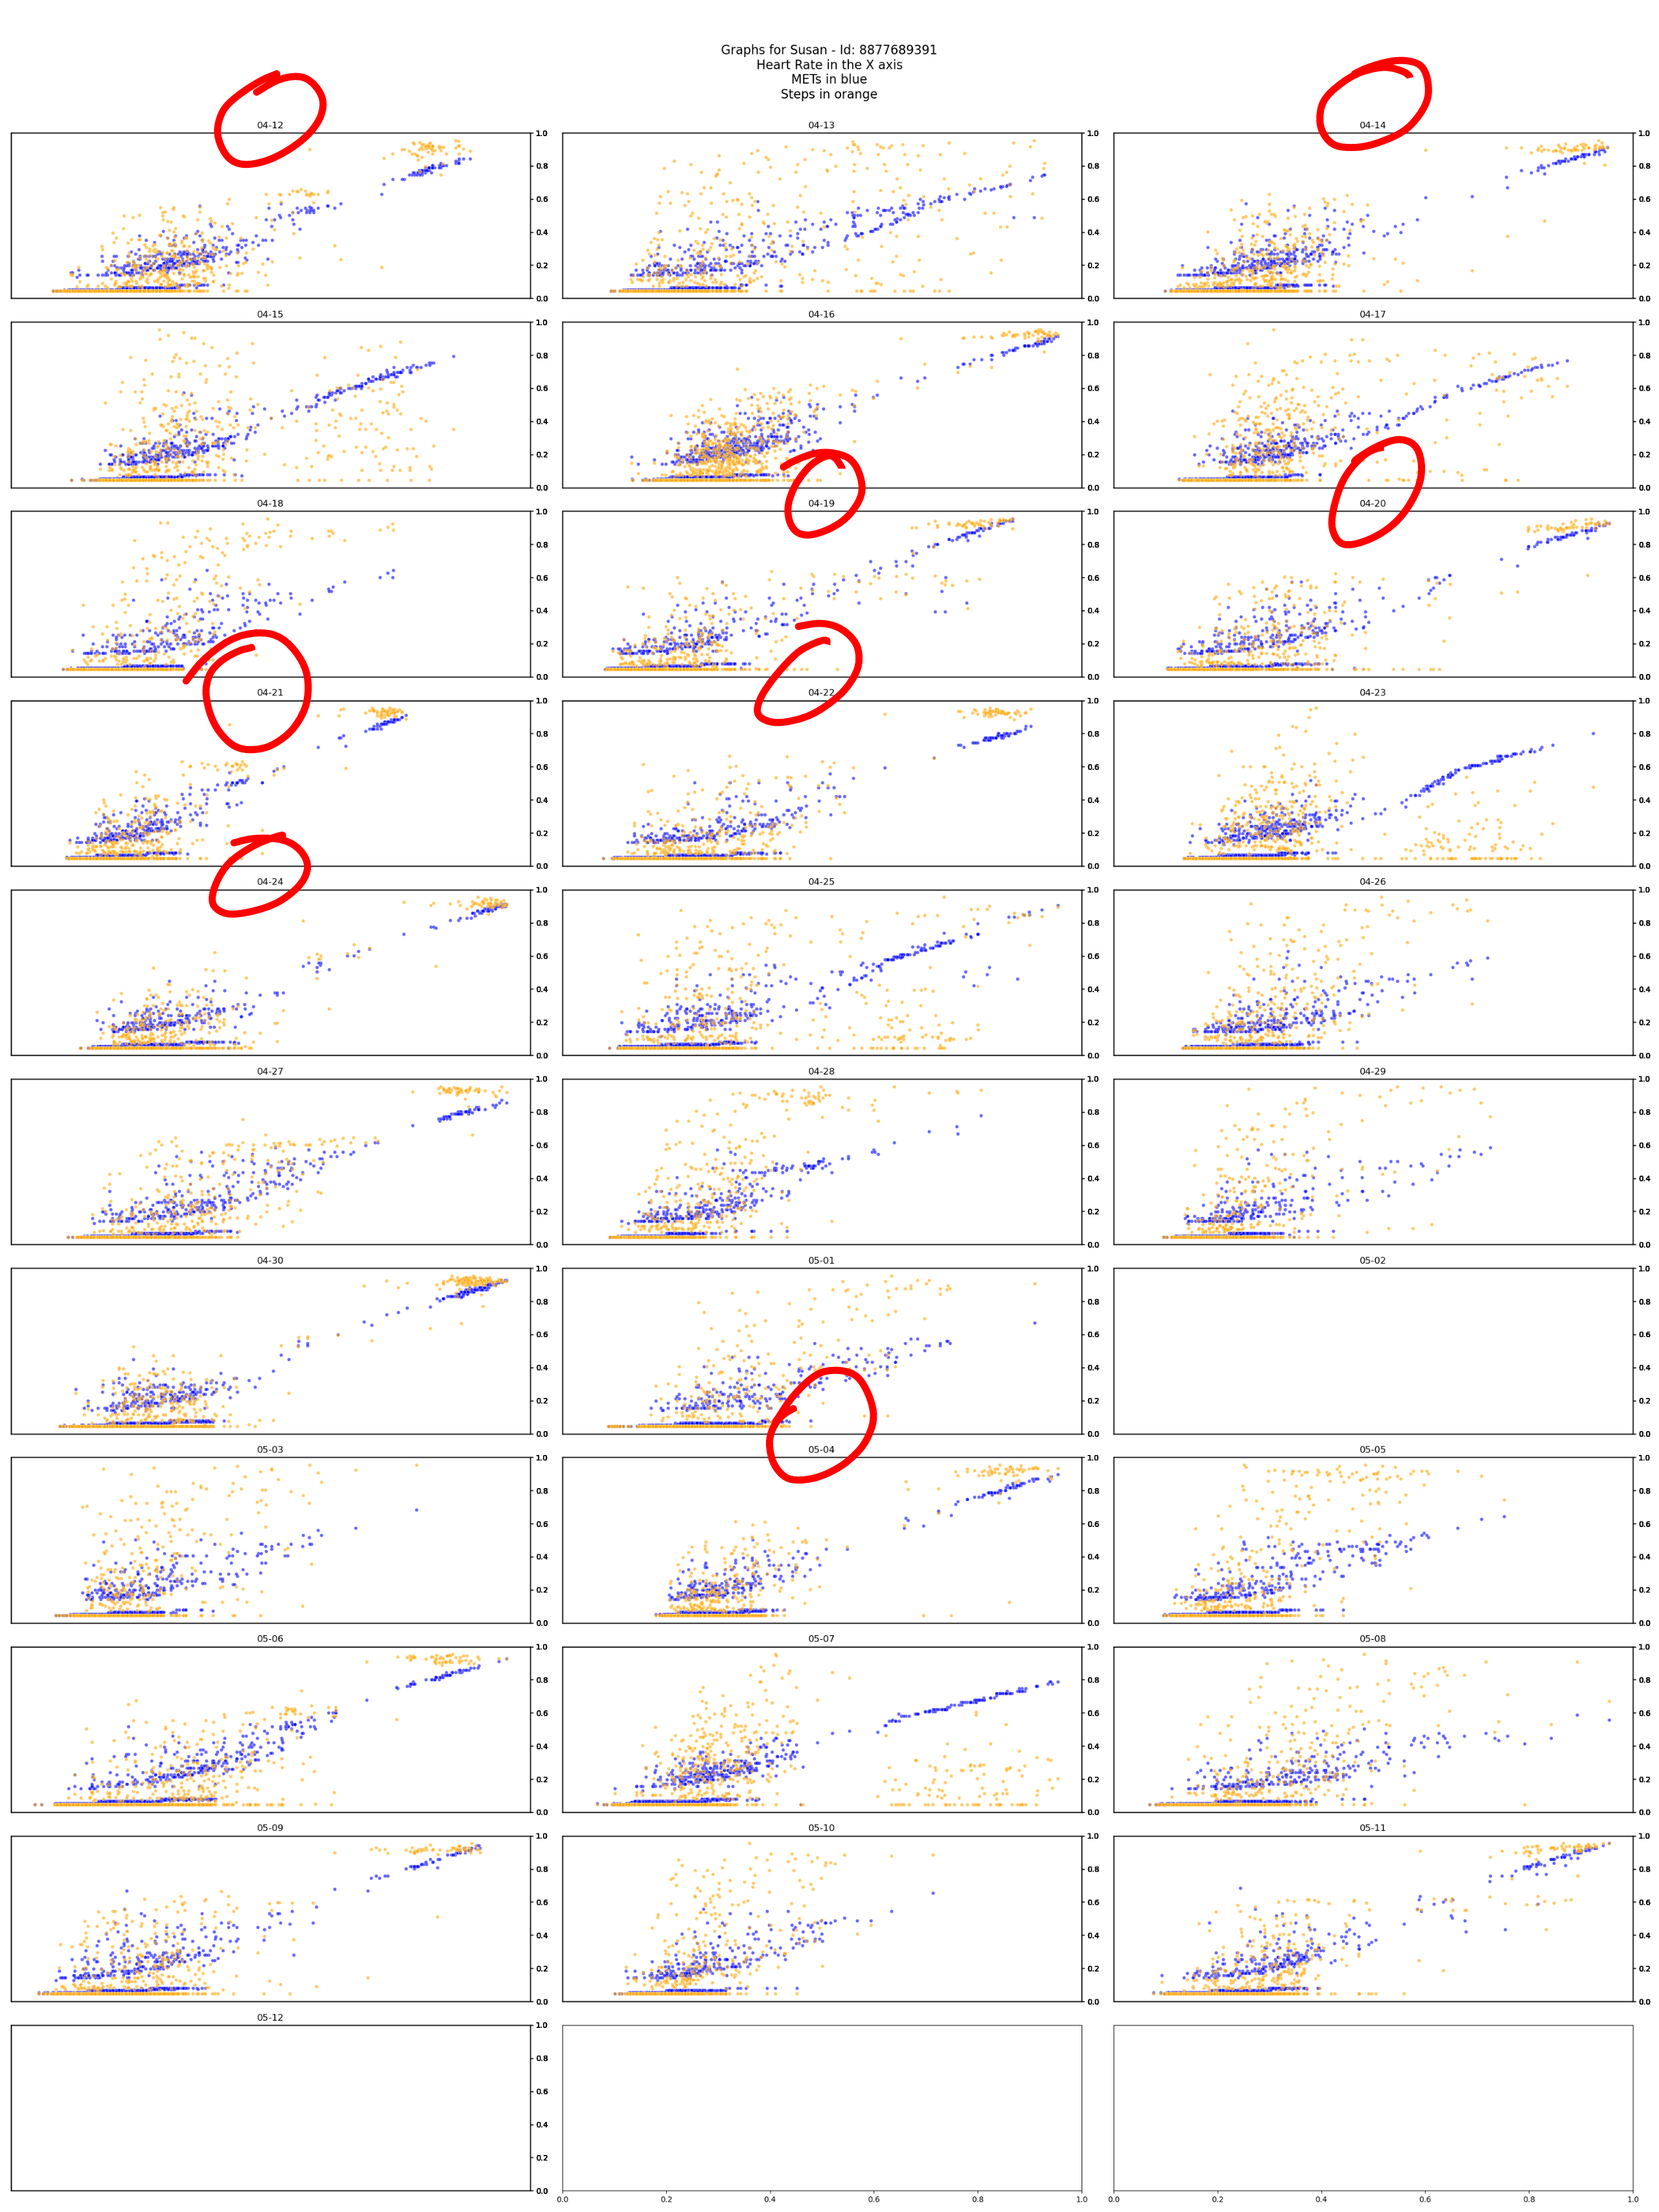

In [15]:
Image(filename='../Graphs_heart_rate_METs_Steps/iMarkup_20230822_145446.png') 

## Plotting chosen Data for training

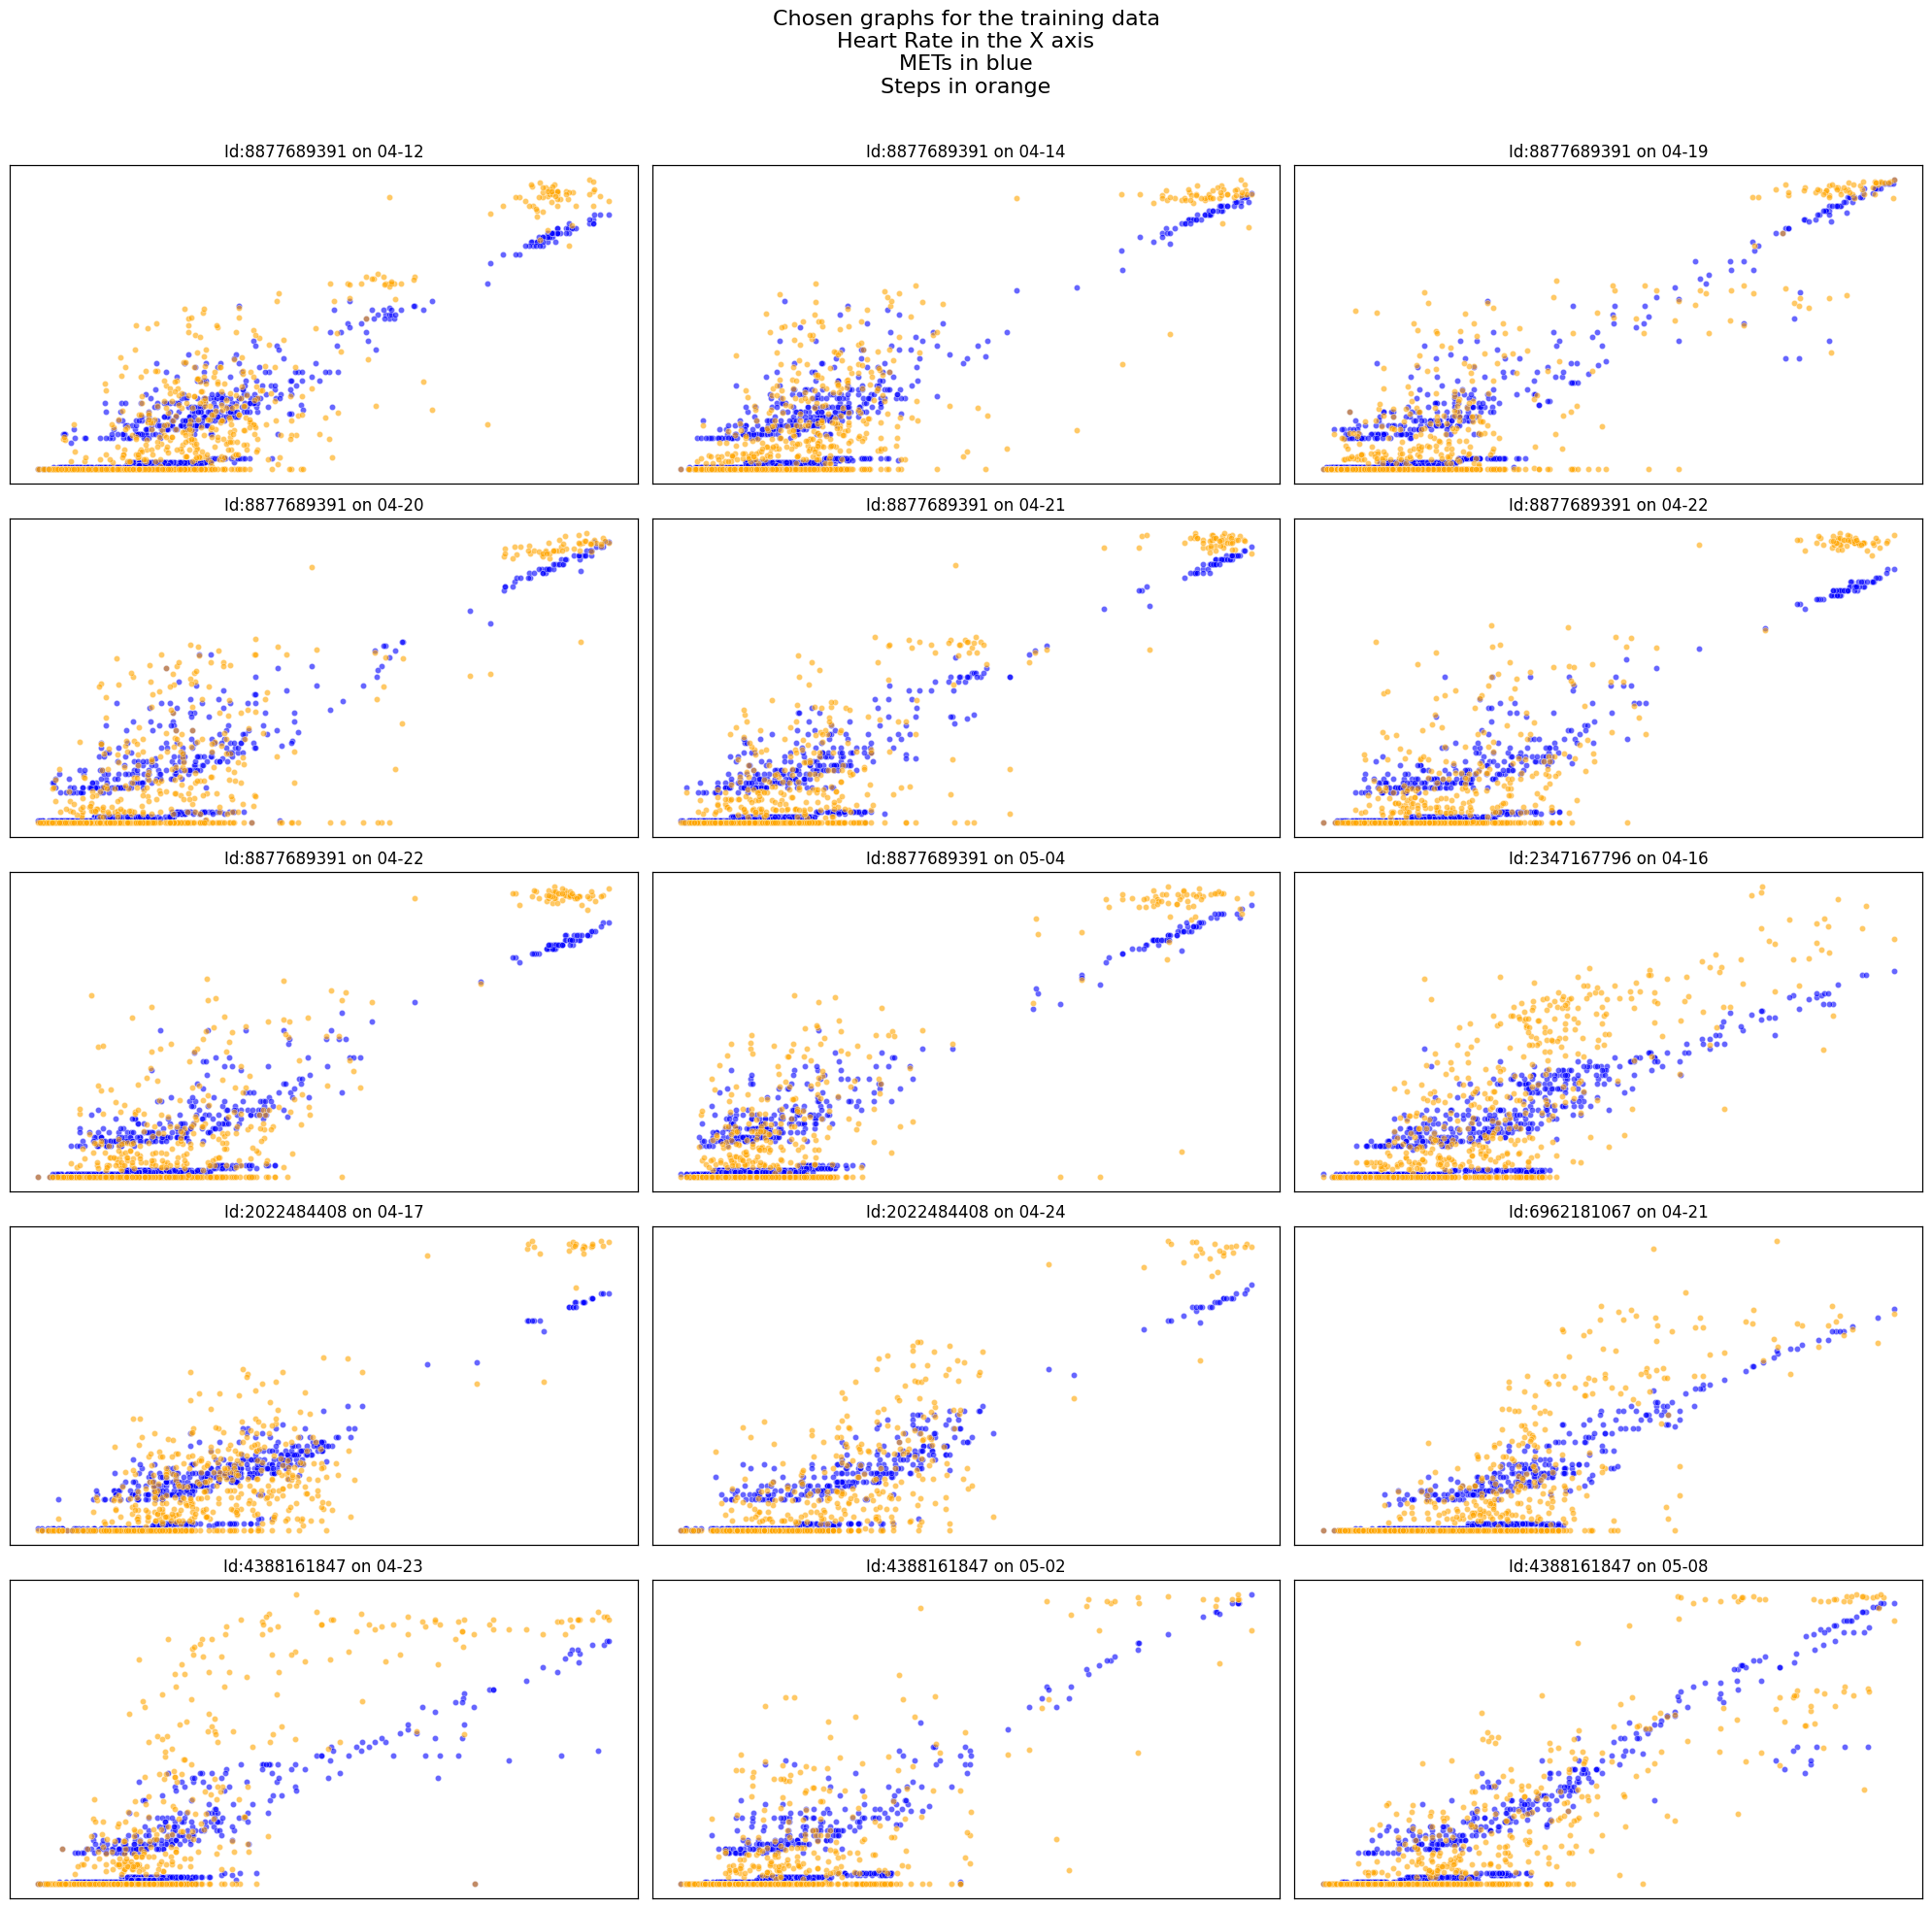

In [16]:
chosen_graphs = {
	8877689391:[
		'04-12', '04-14', '04-19', '04-20', '04-21', '04-22', '04-22', '05-04'
	],
	2347167796:[
		'04-16'
	],
	2022484408:[
		'04-17', '04-24'
	],
	6962181067:[
		'04-21'
	],
	4388161847:[
		'04-23', '05-02', '05-08'
	]
}

num_graphs = 0
for _, days in chosen_graphs.items():
	num_graphs += len(days)

n_cols = 3
fig, axs = plt.subplots(int(np.ceil(num_graphs / n_cols)), n_cols, figsize=(20,20), sharey=True)
axs = iter(axs.flatten())

for id, days in chosen_graphs.items():
	for day in days:
		curr_ax = next(axs)
		df_curr_id_day = df_only_more_10_days[(df_only_more_10_days['date'] == day) & (df_only_more_10_days['Id'] == id)]
		scatter_size = 20
		scatter_alpha = 0.6
		sns.scatterplot(data=df_curr_id_day, x='heart_rate', y='METs', ax=curr_ax, color='blue', alpha=scatter_alpha, s=scatter_size)
		twinaxs.append(sns.scatterplot(data=df_curr_id_day, x='heart_rate', y='Steps', ax=curr_ax.twinx(), color='orange', alpha=scatter_alpha, s=scatter_size))

		curr_ax.set(
			xticks=[],
			xlabel='',
			title=f'Id:{id} on {day}',
			ylabel='',
			yticks=[]
		)

		twinaxs[-1].set(
			ylabel='',
			yticks=[]
		)
		
fig.suptitle(f'Chosen graphs for the training data\n'+
				'Heart Rate in the X axis\n'+
				'METs in blue\n'+
				'Steps in orange', fontsize=16)

fig.tight_layout()
fig.subplots_adjust(top=0.90)

# Creating the Dataset for training and saving in a pickle file

In [17]:
df_only_more_10_days['train'] = False

for id, days in chosen_graphs.items():
	for day in days:
		df_only_more_10_days.loc[(df_only_more_10_days['date'] == day) & (df_only_more_10_days['Id'] == id), 'train'] = True

print('Number of datapoints for the train dataset: ', df_only_more_10_days['train'].sum())
print('Total datapoints on the dataset: ', len(df_only_more_10_days))
df_only_more_10_days.head()

Number of datapoints for the train dataset:  14026
Total datapoints on the dataset:  318249


date     Name          Id                                  time_range                Time  METs  Steps  heart_rate  train
0  04-12  Barbara  7007744171  (2016-04-12 05:36:00, 2016-04-12 05:37:00] 2016-04-12 05:36:30  10.0    0.0  101.000000  False
1  04-12  Barbara  7007744171  (2016-04-12 06:03:00, 2016-04-12 06:04:00] 2016-04-12 06:03:05  10.0    0.0   70.000000  False
2  04-12  Barbara  7007744171  (2016-04-12 06:26:00, 2016-04-12 06:27:00] 2016-04-12 06:26:30  30.0   10.0   97.250000  False
3  04-12  Barbara  7007744171  (2016-04-12 06:27:00, 2016-04-12 06:28:00] 2016-04-12 06:27:05  36.0   28.0   98.800000  False
4  04-12  Barbara  7007744171  (2016-04-12 06:28:00, 2016-04-12 06:29:00] 2016-04-12 06:28:05  40.0   45.0  101.888889  False

In [18]:
df_only_more_10_days.to_pickle('reduced_dataset_with_train_data.pickle')